In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import pdb

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [3]:
batch_size = 20

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

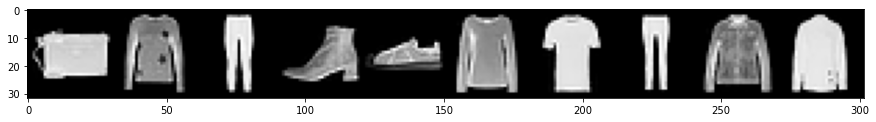

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(images[:10], nrow=10))
plt.show()

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
device

'cuda:0'

## Simple Autoencoder

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
#         self.encoder = nn.Linear(784, encoding_dim)
#         self.decoder = nn.Linear(encoding_dim, 784)
        self.encoder = nn.Sequential(nn.Linear(784,392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, encoding_dim))
        
        self.decoder = nn.Sequential(nn.Linear(encoding_dim, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 784))

    def forward(self, x):
        x = F.relu(self.encoder(x))
        x = F.sigmoid(self.decoder(x))
        return x

encoding_dim = 64
model = Autoencoder(encoding_dim)

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

## Training

In [11]:
n_epochs = 20

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for data in trainloader:
        images, _ = data
        images = images.view(images.size(0), -1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
            
    lr_scheduler.step()
    train_loss = train_loss/len(trainloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


Epoch: 1 	Training Loss: 0.474006
Epoch: 2 	Training Loss: 0.367070
Epoch: 3 	Training Loss: 0.332335
Epoch: 4 	Training Loss: 0.312522
Epoch: 5 	Training Loss: 0.297770
Epoch: 6 	Training Loss: 0.285200
Epoch: 7 	Training Loss: 0.277967
Epoch: 8 	Training Loss: 0.269650
Epoch: 9 	Training Loss: 0.263967
Epoch: 10 	Training Loss: 0.258246
Epoch: 11 	Training Loss: 0.253012
Epoch: 12 	Training Loss: 0.248327
Epoch: 13 	Training Loss: 0.245248
Epoch: 14 	Training Loss: 0.241059
Epoch: 15 	Training Loss: 0.238660
Epoch: 16 	Training Loss: 0.235909
Epoch: 17 	Training Loss: 0.233261
Epoch: 18 	Training Loss: 0.230543
Epoch: 19 	Training Loss: 0.228755
Epoch: 20 	Training Loss: 0.226684


## Testing on a random batch

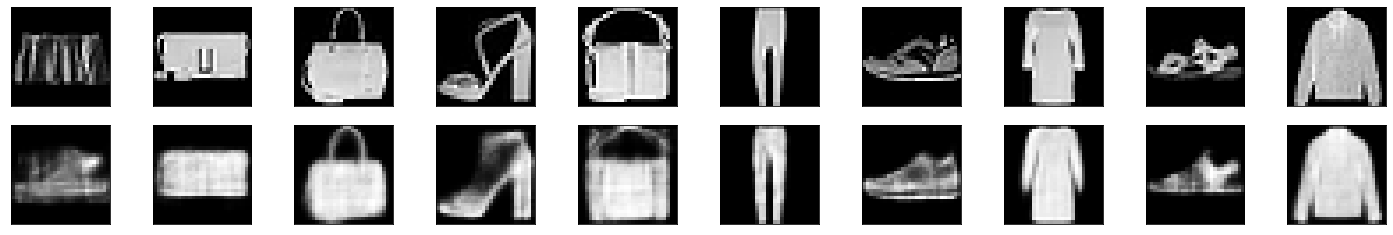

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
output = model(images_flatten)
images = images.numpy()

output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Variational autoencoder

In [43]:
class VAE(nn.Module):
    def __init__(self, hidden_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, hidden_dim)
        self.fc22 = nn.Linear(400, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        z = torch.randn_like(std)
        return mu + z*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE(20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

In [44]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [45]:
log_interval = 50
from torchvision.utils import save_image
history = {'train':[], 'test':[]}
num_epochs = 20

In [46]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm_notebook(trainloader)):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % (6*log_interval) == 0:
            history['train'].append(loss.item()/len(data))
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(trainloader.dataset),
#                 100. * batch_idx / len(trainloader),
#                 loss.item() / len(data)))

    print('====> Epoch: {}/{} Average train loss: {:.4f}'.format(epoch, num_epochs, train_loss / len(trainloader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(testloader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            if i%log_interval == 0:
                history['test'].append(loss.item()/len(data))

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, num_epochs):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 1/20 Average train loss: 263.7109
====> Test set loss: 252.1128


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 2/20 Average train loss: 248.0230
====> Test set loss: 247.6903


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 3/20 Average train loss: 245.3793
====> Test set loss: 246.3440


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 4/20 Average train loss: 243.9960
====> Test set loss: 245.3884


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 5/20 Average train loss: 243.1443
====> Test set loss: 244.5960


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 6/20 Average train loss: 242.5663
====> Test set loss: 243.9699


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 7/20 Average train loss: 242.1174
====> Test set loss: 244.0444


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 8/20 Average train loss: 241.8210
====> Test set loss: 243.3880


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 9/20 Average train loss: 241.5658
====> Test set loss: 244.4639


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 10/20 Average train loss: 241.3220
====> Test set loss: 242.9985


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 11/20 Average train loss: 241.0984
====> Test set loss: 242.9168


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 12/20 Average train loss: 240.9266
====> Test set loss: 242.7876


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 13/20 Average train loss: 240.8065
====> Test set loss: 242.7002


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 14/20 Average train loss: 240.7202
====> Test set loss: 242.3989


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 15/20 Average train loss: 240.5518
====> Test set loss: 242.2149


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 16/20 Average train loss: 240.4513
====> Test set loss: 242.4923


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 17/20 Average train loss: 240.3786
====> Test set loss: 242.2748


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 18/20 Average train loss: 240.3003
====> Test set loss: 242.4857


  0%|          | 0/3000 [00:00<?, ?it/s]

====> Epoch: 19/20 Average train loss: 240.1568
====> Test set loss: 241.8703


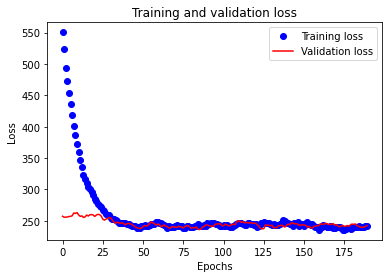

In [49]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

loss_values = smooth_curve(history['train'])
val_loss_values = smooth_curve(history['test'])
epochs = np.arange(len(loss_values))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()